In [1]:
import cv2

In [2]:
#记得指定这是第几版模型
model_version = '14'

In [3]:
#读取图片部分代码来自网络
def read_picture(path,n_C):
    import os
    from PIL import Image
    import numpy as np
    import matplotlib.pyplot as plt
    #function:读取path路径下的图片，并转为形状为[m,n_H,n_W,n_C]的数组
    #path:str,图片所在路径
    #n_C:int,图像维数，黑白图像输入1，rgb图像输入3
    #datas：返回维度为（m，n_H,n_W,n_C）的array（数组）矩阵
    datas=[]
    x_dirs=os.listdir(path)
    for x_file in x_dirs:
        fpath=os.path.join(path,x_file)
        _x=Image.open(fpath)
        n_W=_x.size[1]
        n_H=_x.size[0]
        datas.append(np.array(_x))
        _x.close()  
    datas=np.array(datas)
    
    m=datas.shape[0]
    datas=datas.reshape((m,n_H,n_W,n_C))
    print(datas.shape)
    
    return datas


In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os


base_dir = 'D:\\food_dataset\\food_dataset'
train_dir = os.path.join(base_dir, 'train') 
validation_dir = os.path.join(base_dir, 'validation') 
test_dir = os.path.join(base_dir, 'test')

In [5]:
imgsize = [320,200]

In [6]:
def getDataset(path):
    dset = np.empty([0,imgsize[0],imgsize[1],3],dtype = 'float32')
    dset = np.asarray(dset)
    foodlist = ['donuts','egg_tart','hamburger','ice_cream','pizza','steak']
    for i in range(6):
        tmpdir = os.path.join(path,foodlist[i])
        dset = np.concatenate((dset,read_picture(tmpdir,3)),axis = 0)
    
    return dset

In [7]:
import numpy as np
X_train = getDataset(train_dir)

(922, 320, 200, 3)
(938, 320, 200, 3)
(936, 320, 200, 3)
(928, 320, 200, 3)
(949, 320, 200, 3)
(977, 320, 200, 3)


In [8]:
X_train = np.asarray(X_train)

In [9]:

trainsize = X_train.shape[0]
print(X_train.shape)
print(trainsize)

(5650, 320, 200, 3)
5650


In [10]:
X_validation = getDataset(validation_dir)

(135, 320, 200, 3)
(192, 320, 200, 3)
(167, 320, 200, 3)
(170, 320, 200, 3)
(191, 320, 200, 3)
(182, 320, 200, 3)


In [11]:
valsize = X_validation.shape[0]
print(X_validation.shape)
print(valsize)

(1037, 320, 200, 3)
1037


In [12]:
X_test = getDataset(test_dir)

(100, 320, 200, 3)
(100, 320, 200, 3)
(100, 320, 200, 3)
(100, 320, 200, 3)
(100, 320, 200, 3)
(100, 320, 200, 3)


In [13]:
X_test.shape

(600, 320, 200, 3)

In [14]:
train_datagen = ImageDataGenerator(
                    rescale = 1./255,
                    rotation_range=40,
                    width_shift_range=0.2,
                    height_shift_range=0.2,
                    shear_range=0.2,
                    zoom_range=0.2,
                    horizontal_flip=True,
                    fill_mode='nearest',
                    #以下4行做图像标准化
                    featurewise_center=True, 
                    featurewise_std_normalization=True,
                    samplewise_center=True, 
                    samplewise_std_normalization=True
                    )

In [15]:
train_datagen.fit(X_train)

In [16]:
val_datagen = ImageDataGenerator(rescale = 1./255,
                                #以下4行做图像标准化
                                featurewise_center=True, 
                                featurewise_std_normalization=True,
                                samplewise_center=True, 
                                samplewise_std_normalization=True
                                )

In [17]:
val_datagen.fit(X_validation)

In [18]:
batchsize = 30

In [19]:
train_generator = train_datagen.flow_from_directory(
                    train_dir,
                    target_size = (imgsize[0],imgsize[1]),
                    batch_size = batchsize,
                    )

validation_generator = val_datagen.flow_from_directory(
                    validation_dir,
                    target_size = (imgsize[0],imgsize[1]),
                    batch_size = batchsize,
                    )



Found 5650 images belonging to 6 classes.
Found 1037 images belonging to 6 classes.


In [20]:
from tensorflow.keras.applications.vgg16 import VGG16

conv_base = VGG16(weights='imagenet',
                    include_top=False,
                    input_shape=(imgsize[0], imgsize[1], 3))



conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 320, 200, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 320, 200, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 320, 200, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 160, 100, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 160, 100, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 160, 100, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 80, 50, 128)       0     

In [21]:
from tensorflow.keras import regularizers

In [22]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow import optimizers
from tensorflow.keras.layers import GlobalAveragePooling2D

model = models.Sequential()
model.add(conv_base)
#model.add(layers.Flatten())

model.add(GlobalAveragePooling2D())
#model.add(layers.Dense(128, activation='relu',kernel_regularizer=regularizers.l1_l2(l1 = 0.001, l2 = 0.001)))
#model.add(layers.Dropout(0.5))
#model.add(layers.Dense(64, activation='relu',kernel_regularizer=regularizers.l1_l2(l1 = 0.001, l2 = 0.001)))
model.add(layers.Dense(6, activation='softmax'))

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 10, 6, 512)        14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 6)                 3078      
                                                                 
Total params: 14,717,766
Trainable params: 14,717,766
Non-trainable params: 0
_________________________________________________________________


In [24]:
print('trainable weights: ', len(model.trainable_weights))
conv_base.trainable = True


f = False 
for layer in conv_base.layers:
    if layer.name == 'block2_conv1':
        f = True
    if f == True:
        layer.trainable = True
    else:
        layer.trainable = False

print('trainable weights: ', len(model.trainable_weights))

trainable weights:  28
trainable weights:  24


In [26]:
import tensorflow.keras
callbacks_list = [
    tensorflow.keras.callbacks.ReduceLROnPlateau( # 不再改善时降低学习率
        monitor='loss',
        factor=0.5,
        patience=1,
    ),
    tensorflow.keras.callbacks.EarlyStopping( # 不再改善时中断训练
        monitor='loss',
        patience=5,
    )
]

In [27]:
from tensorflow import optimizers

model.compile(optimizer=optimizers.SGD(lr=1e-2),
                loss='categorical_crossentropy',
                metrics=['acc'])

history = model.fit_generator(
                    train_generator,
                    steps_per_epoch=trainsize/batchsize,
                    epochs=300,
                    validation_data=validation_generator,
                    validation_steps=valsize/batchsize,
                    callbacks = callbacks_list)


d:\python3.8\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)
C:\Users\Nickelth\AppData\Local\Temp\ipykernel_19288\224217198.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/300
188/188 [==============================] - 111s 525ms/step - loss: 1.7685 - acc: 0.2411 - val_loss: 1.6229 - val_acc: 0.3722 - lr: 0.0100
Epoch 2/300
188/188 [==============================] - 121s 643ms/step - loss: 1.3553 - acc: 0.4763 - val_loss: 0.8872 - val_acc: 0.7416 - lr: 0.0100
Epoch 3/300
188/188 [==============================] - 117s 619ms/step - loss: 0.8790 - acc: 0.7009 - val_loss: 0.4091 - val_acc: 0.8505 - lr: 0.0100
Epoch 4/300
188/188 [==============================] - 113s 599ms/step - loss: 0.5844 - acc: 0.8041 - val_loss: 0.2943 - val_acc: 0.9045 - lr: 0.0100
Epoch 5/300
188/188 [==============================] - 112s 594ms/step - loss: 0.5252 - acc: 0.8322 - val_loss: 0.3418 - val_acc: 0.8949 - lr: 0.0100
Epoch 6/300
188/188 [==============================] - 116s 611ms/step - loss: 0.5004 - acc: 0.8303 - val_loss: 0.2964 - val_acc: 0.8987 - lr: 0.0100
Epoch 7/300
188/188 [==============================] - 126s 667ms/step - loss: 0.3708 - acc: 0.8719 

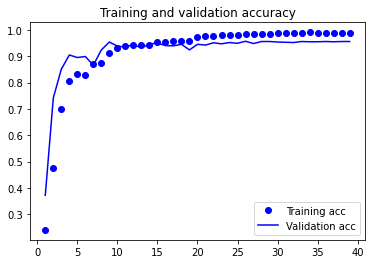

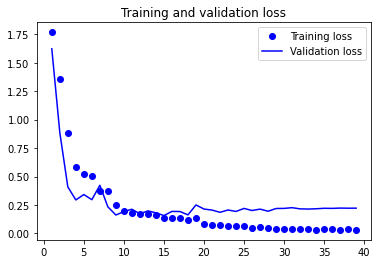

In [28]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [29]:
s = 'food_recognize_model' + model_version + '.h5'

In [30]:
print(s)

food_recognize_model14.h5


In [31]:
model.save(s)

In [32]:


test_datagen = ImageDataGenerator(rescale = 1./255,
                                 #以下4行做图像标准化
                                 featurewise_center=True, 
                                 featurewise_std_normalization=True,
                                 samplewise_center=True, 
                                 samplewise_std_normalization=True)
test_datagen.fit(X_test)


test_generator = test_datagen.flow_from_directory(
                    test_dir,
                    target_size = (imgsize[0],imgsize[1]),
                    batch_size =batchsize
                    )

Found 600 images belonging to 6 classes.


In [33]:
model.evaluate_generator(test_generator)

C:\Users\Nickelth\AppData\Local\Temp\ipykernel_19288\2205837447.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  model.evaluate_generator(test_generator)


[0.3476089835166931, 0.9166666865348816]

In [34]:
test_datagen = ImageDataGenerator(rescale = 1./255)

test_generator = test_datagen.flow_from_directory(
                    test_dir,
                    target_size = (imgsize[0],imgsize[1]),
                    batch_size =batchsize
                    )

Found 600 images belonging to 6 classes.


In [35]:
model.evaluate_generator(test_generator)

C:\Users\Nickelth\AppData\Local\Temp\ipykernel_19288\2205837447.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  model.evaluate_generator(test_generator)


[2.8548147678375244, 0.18833333253860474]